# Airbnb Revenue Prediction with XGBoost
--------------------------------------
This script builds a machine learning pipeline to predict Airbnb listing revenue.
It includes:
- Preprocessing of numerical and categorical features
- An XGBoost regressor with tuned hyperparameters
- Model evaluation (train/validation MAE)
- Feature importance analysis
- Learning curve visualization

This project was originally developed as part of my Machine Learning course. The dataset (train.json and test.json) was provided by the professor, and is not publicly available.

## Imports 

In [1]:
import pandas as pd
import numpy as np
import json, zipfile, logging

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


## Defining a baseline function containing the XGBoost Regressor

In [2]:
def baseline():

    """
    Train an XGBoost regression pipeline on the Airbnb dataset.
    
    Returns:
    --------
    best_model : Fitted pipeline with preprocessing & XGBRegressor.
    grid_search : Grid search object if tuning was run, else None
    
    """
    logging.info("Reading train and test files")
    train = pd.read_json("train.json", orient='records')
    test = pd.read_json("test.json", orient='records')
    seed = 123

    # Split train into train and validation
    train, valid = train_test_split(train, test_size=1/3, random_state=seed)
    
    # Create preprocessing pipeline
    preprocess = ColumnTransformer(
        transformers=[
            # Numerical features - impute then scale
            ("numerical", Pipeline(steps=[
                ('imputer', IterativeImputer(random_state=seed, max_iter=10)),
                ('scaler', StandardScaler())
            ]), ["lat", "lon", "bathrooms", "rooms", "guests", "num_reviews", "rating", "min_nights"]),
            
           # Categorical features - impute then one-hot encode
            ("categorical", Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), ["room_type", "cancellation"]),
         ],
        remainder='drop'
    )

    label = 'revenue'

    xgb_regressor = Pipeline(steps=[
        ('preprocess', preprocess),
        ('xgb', XGBRegressor(
            n_estimators=300,
            max_depth=3,
            min_child_weight=5,
            learning_rate=0.1,
            reg_alpha=2,
            reg_lambda=3,
            gamma=1,
            subsample=0.7,
            colsample_bytree=0.7,
            random_state=seed,
            n_jobs=-1,
            eval_metric='mae'
        ))
    ])

    X_train = train.drop([label], axis=1)
    y_train = np.log1p(train[label].values)
    
    # Optional: Uncomment this block to perform grid search tuning
    # (Warning: VERY computationally expensive)
    
    '''
    logging.info("Starting grid search for hyperparameter tuning...")
    
    xgb_regressor = Pipeline(steps=[
        ('preprocess', preprocess),
        ('xgb', XGBRegressor(
            random_state=seed,
            n_jobs=-1,
            eval_metric='mae'
        ))
    ])

    param_grid = {
        'xgb__max_depth': [3, 5],
        'xgb__min_child_weight': [3, 5, 7],
        'xgb__gamma': [0, 1],
        'xgb__reg_alpha': [0, 1, 2],
        'xgb__reg_lambda': [1, 3, 5],
        'xgb__subsample': [0.7, 0.8],
        'xgb__colsample_bytree': [0.7, 0.8],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__n_estimators': [300, 400, 500]
    }

    grid_search = GridSearchCV(
        xgb_regressor, 
        param_grid, 
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best CV score (neg MAE): {grid_search.best_score_:.4f}')

    '''

    # Comment out if running grid search
    xgb_regressor.fit(X_train, y_train)
    best_model = xgb_regressor  
    grid_search = None

    logging.info("Evaluating model performance...")
    
    for split_name, split in [("Train", train), ("Valid", valid)]:
        X_split = split.drop([label], axis=1)
        y_true = split[label].values
        
        # Predict and reverse log transform
        y_pred_log = best_model.predict(X_split)
        y_pred = np.expm1(y_pred_log)
        
        mae = mean_absolute_error(y_true, y_pred)
        
        logging.info(f"{split_name:>5} - MAE: {mae:.3f}")

    # Note: The professor provided a separate test set with hidden labels. 
    # This block is left here to demonstrate how to write predictions into the test.json file
    
    '''
    logging.info("Generating test predictions...")
    pred_test_log = best_model.predict(test)
    pred_test = np.expm1(pred_test_log)
    
    # Ensure no negative predictions
    pred_test = np.maximum(pred_test, 0)
    
    test[label] = pred_test
    predicted = test[['revenue']].to_dict(orient='records')

    # Save predictions
    logging.info("Saving predictions to baseline.zip...")
    with zipfile.ZipFile("baseline.zip", "w", zipfile.ZIP_DEFLATED) as zipf:
        zipf.writestr("redicted.json", json.dumps(predicted, indent=2))
    
    logging.info("Pipeline completed successfully!")
    '''
    
    return best_model, grid_search, train, valid


# Defining a function to analyze feature importance

In [3]:
def analyze_feature_importance(best_model, numeric_features, categorical_features):
    
    try:
        # get fitted XGBRegressor
        model = best_model.named_steps['xgb']
        
        # feature names (numeric + one-hot encoded categorical)
        feature_names = list(numeric_features) + \
                        list(best_model.named_steps['preprocess']
                             .named_transformers_['categorical']
                             .get_feature_names_out(categorical_features))

        # importance values
        importances = model.feature_importances_

        # pair up names + values
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)

        print("\nFeature Importance Rankings:")
        print("----------------------------------------")
        for i, row in importance_df.iterrows():
            print(f"{i+1:2}. {row['feature']:<25}: {row['importance']:.4f}")

        return importance_df
    
    except Exception as e:
        logging.warning(f"Could not analyze feature importance: {e}")


## Defining a function to plot learning curves

In [4]:
def plot_learning_curves(model, X_train, y_train):
    
    try:
        from sklearn.model_selection import learning_curve
        import matplotlib.pyplot as plt
        
        train_sizes, train_scores, valid_scores = learning_curve(
            model, X_train, y_train, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='neg_mean_absolute_error'
        )
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, -train_scores.mean(axis=1), 'o-', label='Training Score')
        plt.plot(train_sizes, -valid_scores.mean(axis=1), 'o-', label='Validation Score')
        plt.xlabel('Training Set Size')
        plt.ylabel('Mean Absolute Error')
        plt.title('Learning Curves')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    except ImportError:
        logging.info("matplotlib not available - skipping learning curves")
    except Exception as e:
        logging.warning(f"Could not plot learning curves: {e}")


## Executing XGBoost 

2025-08-19 17:15:44,171 - INFO - Reading train and test files
2025-08-19 17:15:44,668 - INFO - Evaluating model performance...
2025-08-19 17:15:44,700 - INFO - Train - MAE: 8753.519
2025-08-19 17:15:44,730 - INFO - Valid - MAE: 8783.675



Feature Importance Rankings:
----------------------------------------
 3. bathrooms                : 0.1566
 9. room_type_entire_home    : 0.1480
 4. rooms                    : 0.1429
 6. num_reviews              : 0.1228
11. room_type_private_room   : 0.0782
 2. lon                      : 0.0579
 5. guests                   : 0.0541
 7. rating                   : 0.0411
 1. lat                      : 0.0295
12. room_type_shared_room    : 0.0295
19. cancellation_Super Strict 30 Days: 0.0262
14. cancellation_Flexible    : 0.0206
 8. min_nights               : 0.0194
13. cancellation_Firm        : 0.0162
20. cancellation_Super Strict 60 Days: 0.0159
10. room_type_hotel_room     : 0.0139
15. cancellation_Moderate    : 0.0098
21. cancellation_None        : 0.0091
18. cancellation_Strict      : 0.0083
16. cancellation_Non-refundable: 0.0000
17. cancellation_Refundable  : 0.0000


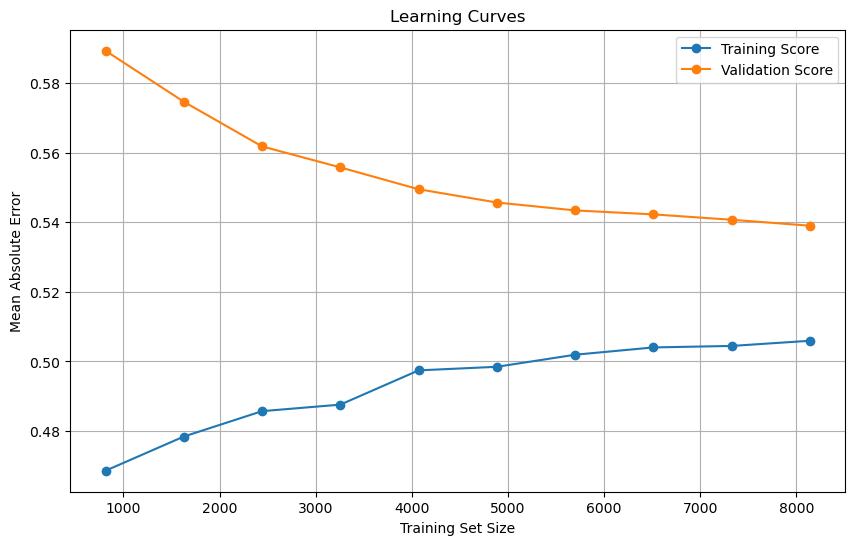

In [5]:
if __name__ == '__main__':
    
    try:
        best_model, grid_search, train, valid = baseline()
        
        # Analyze feature importance
        numeric_features = ["lat", "lon", "bathrooms", "rooms", "guests", "num_reviews", "rating", "min_nights"]
        categorical_features = ["room_type", "cancellation"]
        
        analyze_feature_importance(best_model, numeric_features, categorical_features)
        
        # plot learning curves        
        plot_learning_curves(best_model, train.drop(['revenue'], axis=1), np.log1p(train['revenue'].values))
        
    except Exception as e:
        logging.error(f"Pipeline failed with error: {e}")
        raise